# Invasion of 042 into Caco-2 cells

In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from matplotlib.patches import Ellipse
from scipy import stats
from tqdm.notebook import tqdm as tqdm

Import data and features from data set

In [2]:
datum = pd.read_csv('Data/042.csv') 

Time=datum.iloc[:, 0].values
LogDose=datum.iloc[:, 1].values
CFU=datum.iloc[:, 2].values
LogCFU=datum.iloc[:, 3].values
Rate=datum.iloc[:, 4].values
LogRate=datum.iloc[:, 5].values

def classification(column):
    CLASS=sorted(list(set(column)))
    return CLASS

class_LogDose=classification(LogDose)

Initial_8=datum[datum["LogDose"]==class_LogDose[5]]
Initial_7=datum[datum["LogDose"]==class_LogDose[4]]
Initial_6=datum[datum["LogDose"]==class_LogDose[3]]
Initial_5=datum[datum["LogDose"]==class_LogDose[2]]
Initial_4=datum[datum["LogDose"]==class_LogDose[1]]
Initial_3=datum[datum["LogDose"]==class_LogDose[0]]

datum=deepcopy(datum.dropna())
Initial_8=deepcopy(Initial_8.dropna())
Initial_7=deepcopy(Initial_7.dropna())
Initial_6=deepcopy(Initial_6.dropna())
Initial_5=deepcopy(Initial_5.dropna())
Initial_4=deepcopy(Initial_4.dropna())
Initial_3=deepcopy(Initial_3.dropna())

Fitting=pd.concat([Initial_4, Initial_6, Initial_8])

datum = datum.reset_index()
datum

,index,Time,LogDose,CFU,LogCFU,Rate,LogRate
0,0,0.002778,8.748188,11.940299,1.077015,7.140000e-08,-7.146128
1,1,0.002778,8.748188,5.970149,0.775985,3.570000e-08,-7.447158
2,2,0.002778,8.748188,8.955224,0.952076,5.360000e-08,-7.271067
3,3,1.500000,8.748188,8955.223881,3.952076,5.360000e-05,-4.271067
4,4,1.500000,8.748188,17910.447760,4.253106,1.071430e-04,-3.970037
...,...,...,...,...,...,...,...
137,156,10.500000,3.447158,1.492537,0.173925,1.785714e-03,-2.748188
138,158,10.500000,3.447158,1.492537,0.173925,1.785714e-03,-2.748188
139,159,12.000000,3.447158,5.970149,0.775985,7.142857e-03,-2.146128
140,160,12.000000,3.447158,7.462687,0.872895,8.928571e-03,-2.049218


Estimating posterior dist. with MCMC sampling

In [3]:
sm1 = pickle.load(open('stan model.pkl', 'rb'))

fit_nuts = sm1.sampling(
    data=dict(LogN=Fitting.LogCFU, t=Fitting.Time, LogNdose=Fitting.LogDose, n=len(Fitting.Time)), 
    iter=3000, chains=4,thin=1,warmup=500, 
    seed=12345, control=dict(adapt_delta=0.80,max_treedepth=20)
    ) 
print(fit_nuts)
#Rhat: Gelman-Rubin

Inference for Stan model: anon_model_88ae00440f82126f876ca01fe1481c55.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
LogNmax            4.69  1.6e-3    0.1   4.49   4.62   4.69   4.75   4.89   3978    1.0
Logmu             -8.23  2.1e-3   0.13  -8.49  -8.32  -8.23  -8.15  -7.99   3875    1.0
sigma              0.49  5.4e-4   0.04   0.42   0.46   0.48   0.51   0.58   5771    1.0
LogPredicted[1]    1.13  7.2e-4   0.07   0.99   1.08   1.13   1.18   1.27   9777    1.0
LogPredicted[2]    1.13  7.2e-4   0.07   0.99   1.08   1.13   1.18   1.27   9777    1.0
LogPredicted[3]    1.13  7.2e-4   0.07   0.99   1.08   1.13   1.18   1.27   9777    1.0
LogPredicted[4]    1.43  7.2e-4   0.07   1.29   1.38   1.43   1.48   1.57   9779    1.0
LogPredicted[5]    1.43  7.2e-4   0.07   1.29   1.38   1.43   1.48   1.57   9779    1.0
LogPredicted[6]    

Import sampled extract

In [4]:
samples = fit_nuts.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)


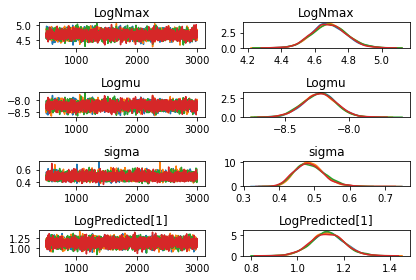

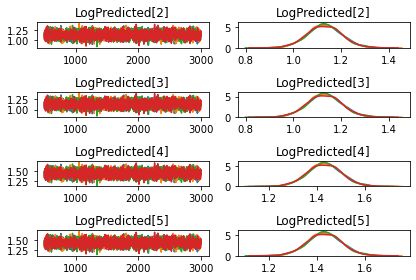

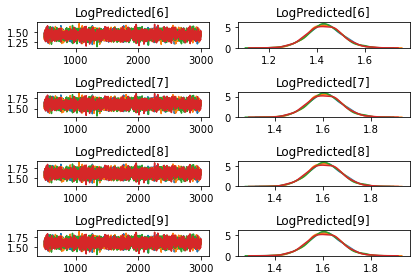

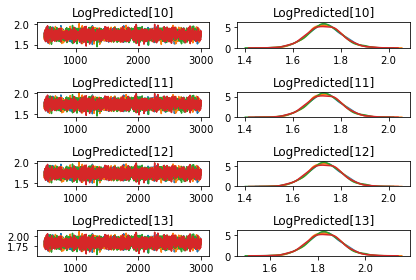

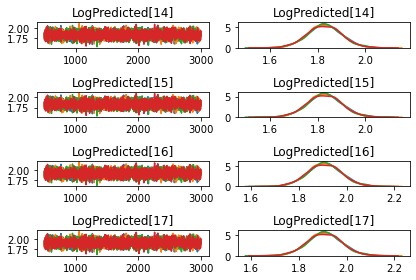

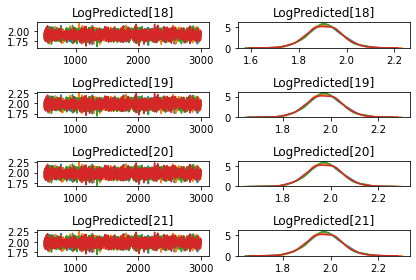

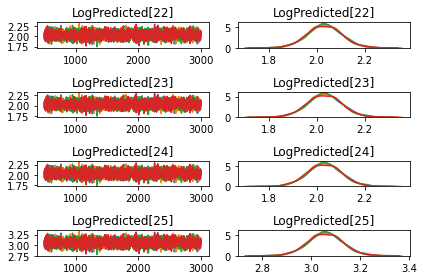

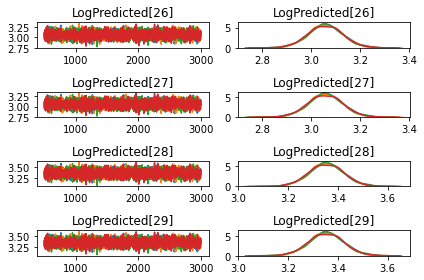

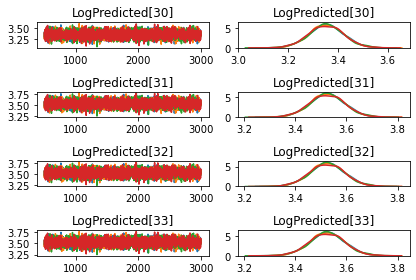

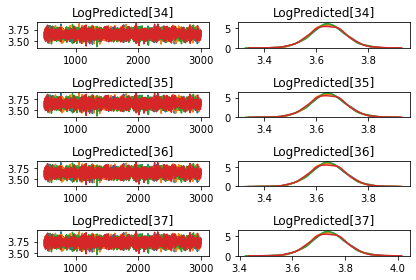

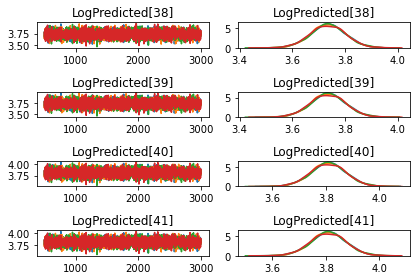

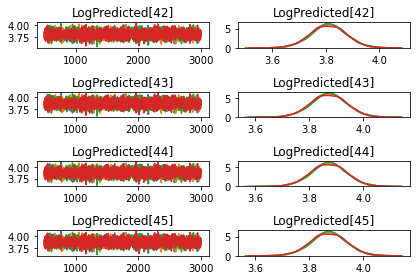

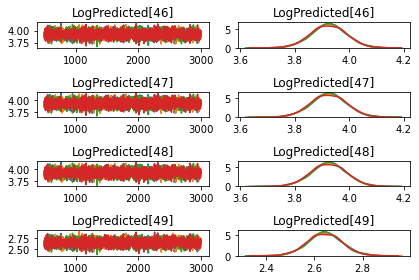

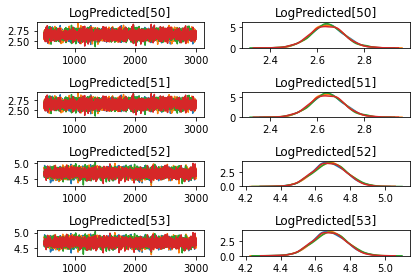

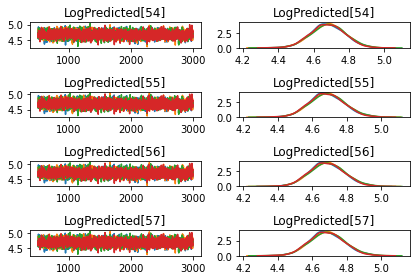

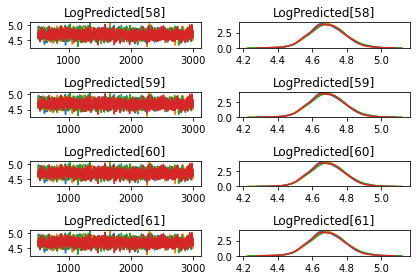

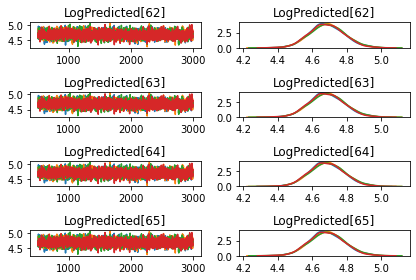

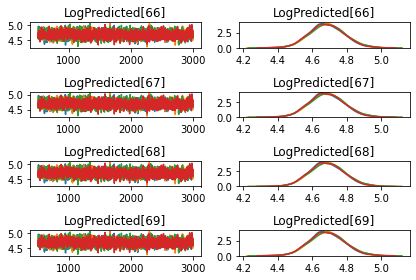

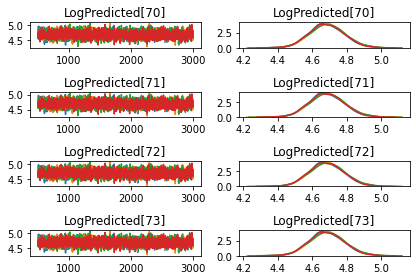

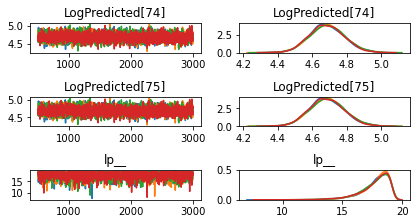

In [5]:
for pg in tqdm(range(num_pages),desc='Progress', leave=False):
    plt.figure()
    pdf = PdfPages("plot/042/Traceplot/Bayesian Fitting Trace"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [6]:
Class_Time=classification(Time)
name = {}
name[5] = Initial_8
name[4] = Initial_7
name[3] = Initial_6
name[2] = Initial_5
name[1] = Initial_4
name[0] = Initial_3

In [7]:
samples = fit_nuts.extract(permuted=True)
devide = 12*60*60
time_interval = np.arange(0, np.max(Class_Time)*(devide+1)/devide, np.max(Class_Time)/devide, dtype="float")

Num_mcmc = len(samples["lp__"])


In [8]:
datum_validation = pd.concat([Initial_4, Initial_6, Initial_8])
datum_validation = datum_validation.reset_index()

def Fit_Model(t,LogNdose, LogNmax,Logmu) :
    return np.log10((10**LogNmax)*(1-np.exp(-1*t*10**(LogNdose+Logmu))))

y_predict_mcmc = np.zeros((len(datum_validation['Time']),Num_mcmc), dtype=float)
y_predict_quantile = np.zeros((len(datum_validation['Time']),5), dtype=float)
y_predict_count = np.zeros((len(datum_validation['Time']),), dtype=float)
y_predict_residual_square = np.zeros((len(datum_validation['Time']),), dtype=float)
for j in tqdm(range(len(datum_validation.Time)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        mu = (Fit_Model(datum_validation.Time[j],datum_validation.LogDose[j],samples["LogNmax"][k], samples["Logmu"][k]))
        sigma = samples["sigma"][k]
        y_predict_mcmc[j,k] = np.random.normal(mu, sigma)
        
    y_predict_quantile[j,:] =  np.quantile(y_predict_mcmc[j,:],[0.005, 0.025, 0.5, 0.975, 0.995])
    y_predict_count[j] = ( (datum_validation.LogCFU[j] < np.quantile(y_predict_mcmc[j,:], [0.995])) &(datum_validation.LogCFU[j] >= np.quantile(y_predict_mcmc[j,:], [0.005]))).sum()
    y_predict_residual_square[j] = (datum_validation.LogCFU[j] - np.quantile(y_predict_mcmc[j,:], [0.5]))**2


print("Validation data count")
print(len(datum_validation['Time']))
print("Accuracy of 99% predictive range")
print(y_predict_count.sum()/len(datum_validation['Time'])*100)
print("RMSE of median")
print((y_predict_residual_square.sum()/len(datum_validation['Time']))**0.5)


Validation data count
75
Accuracy of 99% predictive range
96.0
RMSE of median
0.473598427760942


In [9]:
x=np.arange(0, 12, 0.1, dtype="float")

#LogNdose = np.mean(np.log10(Fitting.N0))
LogNmax = st.median(samples["LogNmax"])
#LogNmax = 4.5
sigma = st.median(samples["sigma"])
Logmu = st.median(samples["Logmu"])
#Logmu = 0.0001
Palette=sns.color_palette(n_colors=len(class_LogDose))

In [10]:
def Fit_Model_for_N(t,LogNdose, LogNmax,Logmu) :
    return (10**LogNmax)*(1-np.exp(-1*t*10**(LogNdose+Logmu)))

def Sample_percentile(t,y_mcmc) :
    prob = [0.5,1,2.5,5,20,50,80,95,97.5,99,99.5]
    exam = [str(n) for n in prob]
    d = np.zeros((len(time_interval),len(prob)+1), dtype=float)
    for j in range(len(time_interval)):
        d[j,0] = time_interval[j]
        for i in range(len(prob)):
            d[j,i+1] = np.percentile(y_mcmc.iloc[j,:], prob[i],axis=0)
    d = pd.DataFrame(d,dtype="float",columns=["Time"]+exam)
    return d

def CLEAN_NAN(X):
    cleanedList = [x for x in X if not (math.isnan(x) == True)]
    return cleanedList 

def CFU_MEAN(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        Timedata.append(np.mean((column[column['Time']==Class_Time[time]])["LogCFU"]))
    return Timedata

def CFU_SD(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        if len((column[column['Time']==Class_Time[time]])["LogCFU"])==0:
            Timedata.append(np.nan)
        elif len((column[column['Time']==Class_Time[time]])["LogCFU"])==1:
            Timedata.append(0)
        else:
            Timedata.append(st.stdev((column[column['Time']==Class_Time[time]])["LogCFU"]))
    return Timedata

def Rate_MEAN(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        Timedata.append(np.mean((column[column['Time']==Class_Time[time]])["LogRate"]))
    return Timedata

def Rate_SD(column):
    Timedata=[]
    for time in range(len(Class_Time)):
        if len((column[column['Time']==Class_Time[time]])["LogCFU"])==0:
            Timedata.append(np.nan)
        elif len((column[column['Time']==Class_Time[time]])["LogCFU"])==1:
            Timedata.append(0)
        else:
            Timedata.append(st.stdev((column[column['Time']==Class_Time[time]])["LogRate"]))
    return Timedata

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


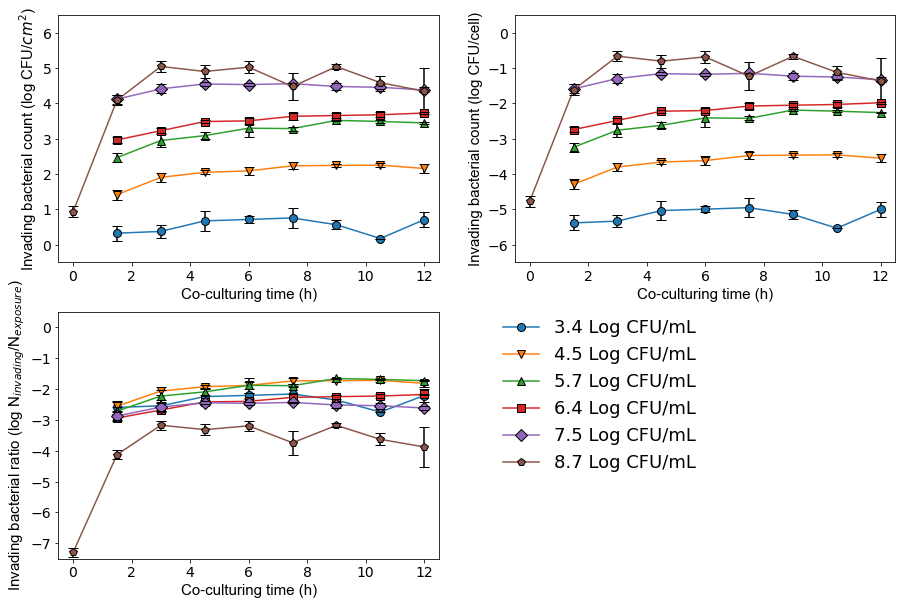

In [11]:
pdf = PdfPages("plot/042/Bacterial Invasion　Bahavior.pdf")
m_shape = ["o", "v", "^", "s", "D", "p"]
plt.figure(1,figsize=(15/2*2,15/3*2))
plt.subplot(2,2,1)
plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial count (log CFU/""$cm^{2}$"")",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i]),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.subplot(2,2,2)
plt.axis([-0.5,12.5,-6.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial count (log CFU/cell)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i])-np.log10(510937.5),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i])-np.log10(510937.5),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.subplot(2,2,3)
plt.axis([-0.5,12.5,-7.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("Invading bacterial ratio (log N"+"$_{invading}$"+"/N"+"$_{exposure}$)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,Rate_MEAN(name[i]),label=str(round(class_LogDose[i],1))+" Log CFU/mL",
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,Rate_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0, fontsize=18,frameon=False)


pdf.savefig()

pdf.close()

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


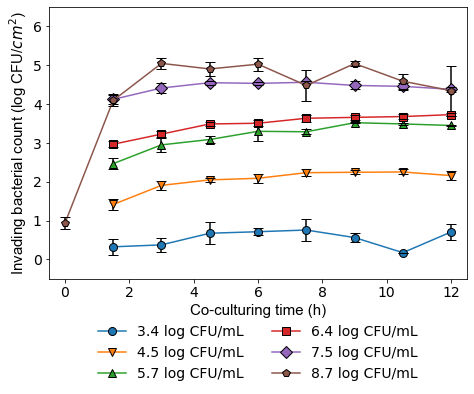

In [12]:
pdf = PdfPages("plot/042/Bacterial Invasion　Count.pdf")
plt.figure(1,figsize=(15/2,15/3))
plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
plt.xticks(size=14)
plt.xticks(np.arange(0, 14, 2))
plt.yticks(size=14)
plt.yticks(np.arange(0, 7, 1))
plt.ylabel("Invading bacterial count (log CFU/""$cm^{2}$"")",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,CFU_MEAN(name[i]),
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i],
        label=str(round(class_LogDose[i],1))+" log CFU/mL"
    )
    plt.errorbar(
        Class_Time,CFU_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )

plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0, fontsize=14, ncol=2, frameon=False)
pdf.savefig(bbox_inches='tight')
pdf.close()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  after removing the cwd from sys.path.


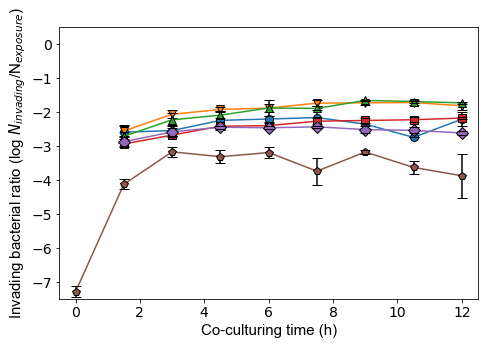

In [13]:
pdf = PdfPages("plot/042/Bacterial Invasion　Ratio.pdf")
plt.figure(1,figsize=(15/2,15/3))

plt.axis([-0.5,12.5,-7.5,0.5],fontname="Arial")
plt.xticks(size=14)
plt.xticks(np.arange(0, 14, 2))
plt.yticks(size=14)
plt.yticks(np.arange(-7, 1, 1))
plt.ylabel("Invading bacterial ratio (log ""$N_{invading}$""/""N$_{exposure}$)",size=15,fontname="Arial")
plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
for i in range(len(class_LogDose)):
    plt.plot(
        Class_Time,Rate_MEAN(name[i]),label=str(round(class_LogDose[i],1))+" log CFU/mL",
        marker=m_shape[i],
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color=Palette[i]
    )
    plt.errorbar(
        Class_Time,Rate_MEAN(name[i]),
        yerr=list(CFU_SD(name[i])),
        fmt="none",
        color="black",
        capsize = 5
    )

pdf.savefig(bbox_inches='tight')
pdf.close()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipyk

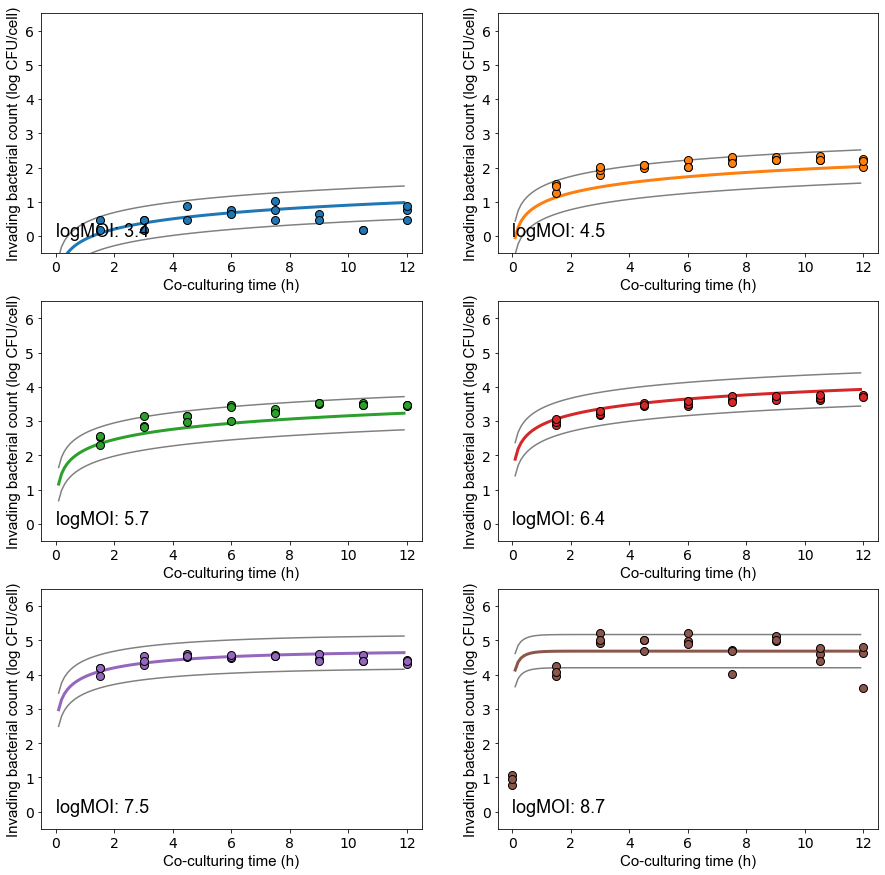

In [14]:
pdf = PdfPages("plot/042/Bayesian Fitted Bacterial Invasion per cell.pdf")

plt.figure(1,figsize=(15,15))

for i in range(len(class_LogDose)):
    plt.subplot(3,2,i+1)
    plt.ylabel("Invading bacterial count (log CFU/cell)",size=15,fontname="Arial")
    plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
    plt.text(0,0,"logMOI: "+str(round(class_LogDose[i],1)),size=18,fontname="Arial")
    plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
    plt.xticks(size=14)
    plt.yticks(size=14)
    LogNdose = class_LogDose[i]
    plt.plot(x,np.log10(Fit_Model_for_N(x,LogNdose, LogNmax,Logmu))+sigma,color="gray")
    plt.plot(x,np.log10(Fit_Model_for_N(x,LogNdose, LogNmax,Logmu))-sigma,color="gray")
    plt.plot(x,np.log10(Fit_Model_for_N(x,LogNdose, LogNmax,Logmu)),color=Palette[i],linewidth=3)
    plt.plot(
        name[i]["Time"],np.log10(name[i]["CFU"]),
        marker="o",
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color="None"
    )

plt.subplots_adjust(wspace=0.2,hspace=0.2)
    

pdf.savefig()

pdf.close()

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


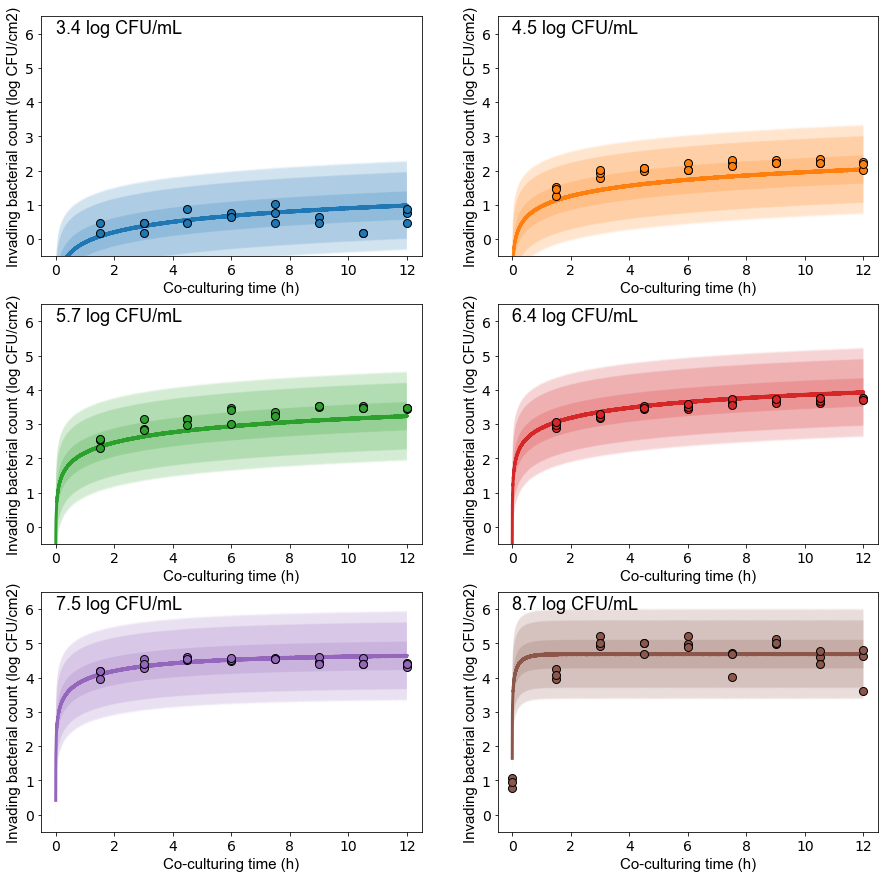

In [15]:
pdf = PdfPages("plot/042/Bayesian Fitted Bacterial Invasion per well.pdf")

plt.figure(1,figsize=(15,15))

for i in tqdm(range(len(class_LogDose)),desc='Progress', leave=False):
    plt.subplot(3, 2, i+1)
    plt.ylabel("Invading bacterial count (log CFU/cm2)",size=15,fontname="Arial")
    plt.xlabel("Co-culturing time (h)",size=15,fontname="Arial")
    plt.text(0,6,str(round(class_LogDose[i],1))+" log CFU/mL",size=18,fontname="Arial")
    plt.axis([-0.5,12.5,-0.5,6.5],fontname="Arial")
    plt.xticks(size=14)
    plt.yticks(size=14)
    LogNdose = class_LogDose[i]
    y_conf_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
    y_predict_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
    for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
        for k in range(Num_mcmc):
            mu = np.log10(Fit_Model_for_N(time_interval[j], LogNdose, samples["LogNmax"][k], samples["Logmu"][k]))
            sigma = samples["sigma"][k]
            y_predict_mcmc[j,k] = np.random.normal(mu, sigma)
    y_predict_mcmc = pd.DataFrame(y_predict_mcmc)
    y_predict_percentile = Sample_percentile(time_interval,y_predict_mcmc)
    plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=Palette[i],linewidth=3)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["0.5"],y_predict_percentile["99.5"],facecolor=Palette[i],alpha=0.2)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=Palette[i],alpha=0.2)
    plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["20"],y_predict_percentile["80"],facecolor=Palette[i],alpha=0.2)
    plt.plot(
        name[i]["Time"],np.log10(name[i]["CFU"]),
        marker="o",
        markersize=8,
        markerfacecolor=Palette[i],
        markeredgecolor="black",
        color="None"
    )

plt.subplots_adjust(wspace=0.2,hspace=0.2)

pdf.savefig(bbox_inches='tight')

pdf.close()

plt.show()

In [16]:
LogNmax = samples["LogNmax"]
Logmu = samples["Logmu"]
sigma = samples["sigma"]
para_matrix  = pd.DataFrame(np.arange(len(LogNmax)*3).reshape(len(LogNmax), 3), columns=["LogNmax", "Logmu", "sigma"])
para_matrix["LogNmax"] = LogNmax
para_matrix["Logmu"] = Logmu
para_matrix["sigma"] = sigma


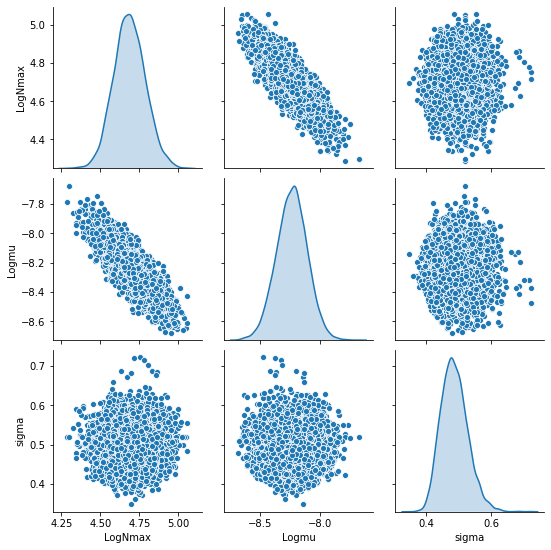

In [17]:
pdf = PdfPages("plot/042/Parameter matrix.pdf")

pg = sns.pairplot(para_matrix, diag_kind='kde')

pdf.savefig()

pdf.close()

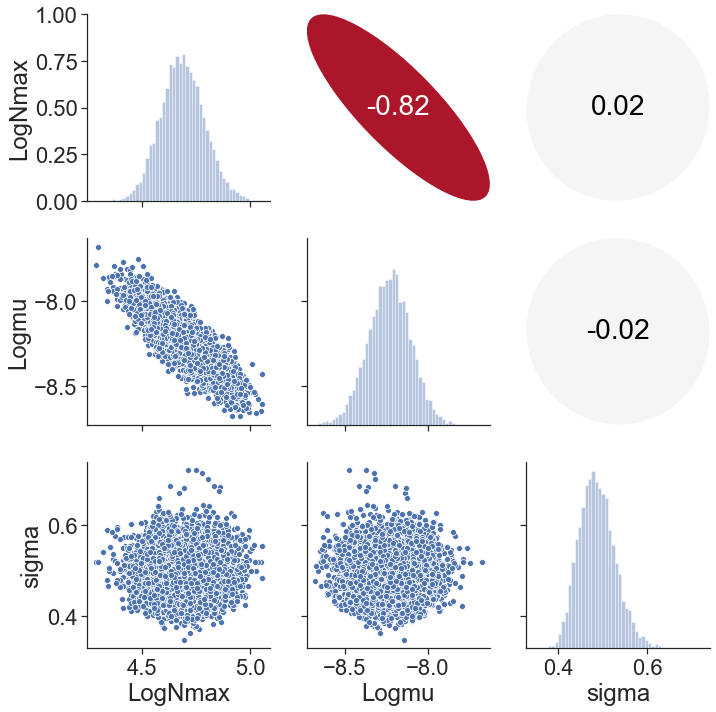

In [18]:
def paramatrix(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.2f}'.format(r), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

LogNmax = samples["LogNmax"]
Logmu = samples["Logmu"]
sigma = samples["sigma"]
para_matrix  = pd.DataFrame(np.arange(len(LogNmax)*3).reshape(len(LogNmax), 3), columns=["LogNmax", "Logmu", "sigma"])
para_matrix["LogNmax"] = LogNmax
para_matrix["Logmu"] = Logmu
para_matrix["sigma"] = sigma
    
pdf = PdfPages("plot/042/Parameter matrix.pdf")

sns.set(font_scale=2)
sns.set_style(style="ticks")
g = sns.PairGrid(para_matrix)
g = g.map_lower(sns.scatterplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(paramatrix)
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)
g.fig.set_figheight(10)
g.fig.set_figwidth(10)

pdf.savefig()

pdf.close()

In [19]:
datum['Time'], datum['LogCFU']

(0       0.002778
 1       0.002778
 2       0.002778
 3       1.500000
 4       1.500000
          ...    
 137    10.500000
 138    10.500000
 139    12.000000
 140    12.000000
 141    12.000000
 Name: Time, Length: 142, dtype: float64,
 0      1.077015
 1      0.775985
 2      0.952076
 3      3.952076
 4      4.253106
          ...   
 137    0.173925
 138    0.173925
 139    0.775985
 140    0.872895
 141    0.474955
 Name: LogCFU, Length: 142, dtype: float64)

In [20]:
y_predict_mcmc = np.zeros((len(datum['Time']),Num_mcmc), dtype=float)
y_predict_quantile = np.zeros((len(datum['Time']),5), dtype=float)
y_predict_count = np.zeros((len(datum['Time']),), dtype=float)
y_predict_residual_square = np.zeros((len(datum['Time']),), dtype=float)
for j in tqdm(range(len(datum.Time)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        mu = np.log10(Fit_Model_for_N(datum.Time[j],datum.LogDose[j],samples["LogNmax"][k], samples["Logmu"][k]))
        sigma = samples["sigma"][k]
        y_predict_mcmc[j,k] = np.random.normal(mu, sigma)
        
    y_predict_quantile[j,:] =  np.quantile(y_predict_mcmc[j,:],[0.005, 0.025, 0.5, 0.975, 0.995])
    y_predict_count[j] = ( (datum.LogCFU[j] < np.quantile(y_predict_mcmc[j,:], [0.995])) &(datum.LogCFU[j] >= np.quantile(y_predict_mcmc[j,:], [0.005]))).sum()
    y_predict_residual_square[j] = (datum.LogCFU[j] - np.quantile(y_predict_mcmc[j,:], [0.5]))**2

    
print("Accuracy of 99% predictive range")
print(y_predict_count.sum()/len(datum['Time']))
print("RMSE of median")
print((y_predict_residual_square.sum()/len(datum['Time']))**0.5)


Accuracy of 99% predictive range
0.9788732394366197
RMSE of median
0.3907807297080537


In [21]:
with open('fit_42.pkl', 'wb') as g:

    pickle.dump(fit_nuts, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until
